In [15]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# from lux.vis.VisList import VisList
# import lux
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from yellowbrick.target import ClassBalance
from yellowbrick.classifier import ROCAUC
from yellowbrick.classifier import PrecisionRecallCurve
from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier import ClassPredictionError
from yellowbrick.classifier import DiscriminationThreshold
import pandas as pd
from typing import List

In [2]:
df = pd.read_csv("../data/hotel_booking.zip")


In [3]:
X = df.drop("is_canceled",axis=1)
y = df['is_canceled']

In [4]:
import pickle,os
import pandas as pd

class Encoder(object):
    def __init__(self,cat_cols=None,path="../../../models/") -> None:
        self.cat_cols = cat_cols
        self.encoders = {}
        self.path = path

    def fit(self,df):

        for col in self.cat_cols:
            print(f"Label encoding - {col}")
            _enc = LabelEncoder()
            _enc.fit_transform(df[col])
            self.encoders[col] = _enc
        return self.encoders

    def transform(self,df:pd.DataFrame):
        if len(self.encoders) <=0:
            print("Encoder Not fitted")
            return 
        for col in self.cat_cols:
            print(f"Label transforming - {col}")
            df[col]=self.encoders[col].transform(df[col])
        return df

    def save(self):
        print("saving ...")
        print(self.path)
        pickle.dump(self.encoders,open(self.path+"encoders.pkl","wb"))
        pickle.dump(self.cat_cols,open(self.path+"encoder_meta","wb"))

    def load(self):
        print("Loading ...")
        self.encoders = pickle.load(open(self.path+"encoders.pkl","rb"))
        self.cat_cols = pickle.load(open(self.path+"encoder_meta","rb"))
        return self.encoders,self.cat_cols

In [5]:
class Predictor(object):
    def __init__(self,models:List=None,path="../../../models/") -> None:
        self.models = models # 1 or 3 models
        self.predictor= {}
        self.path = path

    def fit(self,X,y):
        for model in self.models:
            print("Fitting ...")
            print(model.__name__)
            self.predictor[model.__name__] = model().fit(X,y)
        return self.predictor

    def predict(self,X):
        if len(self.predictor) <=0:
            print("Predictor Not fitted")
            return 
        pred_df = {}
        for model in self.models:
            print(f"predicting with {model.__name__}")
            pred_df[str(model.__name__)] = self.predictor[str(model.__name__)].predict(X)
        return pred_df

    def save(self):
        print("Saving the model...")
        pickle.dump(self.predictor,open(self.path+"model.pkl","wb"))
        pickle.dump(self.models,open(self.path+"model_meta","wb"))

    def load(self):
        print("Loading the model ...")
        self.predictor = pickle.load(open(self.path+"model.pkl","rb"))
        self.models = pickle.load(open(self.path+"model_meta","rb"))

        return self.predictor

In [8]:
DONT_CONSIDER = ['reservation_status_date',"name","email","phone-number","credit_card"]
EXPORT_PATH = "../models/"
cat_cols = df.select_dtypes("object").columns
cat_cols = [col for col in cat_cols if col not in DONT_CONSIDER ]
print(cat_cols)
encoder = Encoder(cat_cols=cat_cols,path=EXPORT_PATH)
encoder.fit(df)
encoder.save()
encoder = Encoder(path=EXPORT_PATH)
encoder.load()

['hotel', 'arrival_date_month', 'meal', 'country', 'market_segment', 'distribution_channel', 'reserved_room_type', 'assigned_room_type', 'deposit_type', 'customer_type', 'reservation_status']
Label encoding - hotel
Label encoding - arrival_date_month
Label encoding - meal
Label encoding - country
Label encoding - market_segment
Label encoding - distribution_channel
Label encoding - reserved_room_type
Label encoding - assigned_room_type
Label encoding - deposit_type
Label encoding - customer_type
Label encoding - reservation_status
saving ...
../models/
Loading ...


({'hotel': LabelEncoder(),
  'arrival_date_month': LabelEncoder(),
  'meal': LabelEncoder(),
  'country': LabelEncoder(),
  'market_segment': LabelEncoder(),
  'distribution_channel': LabelEncoder(),
  'reserved_room_type': LabelEncoder(),
  'assigned_room_type': LabelEncoder(),
  'deposit_type': LabelEncoder(),
  'customer_type': LabelEncoder(),
  'reservation_status': LabelEncoder()},
 ['hotel',
  'arrival_date_month',
  'meal',
  'country',
  'market_segment',
  'distribution_channel',
  'reserved_room_type',
  'assigned_room_type',
  'deposit_type',
  'customer_type',
  'reservation_status'])

In [9]:
enc_df= encoder.transform(df)
enc_df

Label transforming - hotel
Label transforming - arrival_date_month
Label transforming - meal
Label transforming - country
Label transforming - market_segment
Label transforming - distribution_channel
Label transforming - reserved_room_type
Label transforming - assigned_room_type
Label transforming - deposit_type
Label transforming - customer_type
Label transforming - reservation_status


,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,name,email,phone-number,credit_card
0,1,0,342,2015,5,27,1,0,0,2,...,2,0.00,0,0,1,2015-07-01,Ernest Barnes,Ernest.Barnes31@outlook.com,669-792-1661,************4322
1,1,0,737,2015,5,27,1,0,0,2,...,2,0.00,0,0,1,2015-07-01,Andrea Baker,Andrea_Baker94@aol.com,858-637-6955,************9157
2,1,0,7,2015,5,27,1,0,1,1,...,2,75.00,0,0,1,2015-07-02,Rebecca Parker,Rebecca_Parker@comcast.net,652-885-2745,************3734
3,1,0,13,2015,5,27,1,0,1,1,...,2,75.00,0,0,1,2015-07-02,Laura Murray,Laura_M@gmail.com,364-656-8427,************5677
4,1,0,14,2015,5,27,1,0,2,2,...,2,98.00,0,1,1,2015-07-03,Linda Hines,LHines@verizon.com,713-226-5883,************5498
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,0,0,23,2017,1,35,30,2,5,2,...,2,96.14,0,0,1,2017-09-06,Claudia Johnson,Claudia.J@yahoo.com,403-092-5582,************8647
119386,0,0,102,2017,1,35,31,2,5,3,...,2,225.43,0,2,1,2017-09-07,Wesley Aguilar,WAguilar@xfinity.com,238-763-0612,************4333
119387,0,0,34,2017,1,35,31,2,5,2,...,2,157.71,0,4,1,2017-09-07,Mary Morales,Mary_Morales@hotmail.com,395-518-4100,************1821
119388,0,0,109,2017,1,35,31,2,5,2,...,2,104.40,0,0,1,2017-09-07,Caroline Conley MD,MD_Caroline@comcast.net,531-528-1017,************7860


In [26]:
from sklearn.model_selection import train_test_split 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [27]:
X_train

,hotel,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,name,email,phone-number,credit_card
67587,City Hotel,161,2017,May,18,5,0,2,2,0.0,...,Transient,120.00,0,0,Canceled,2016-11-25,Anna Rodgers,Anna.R51@gmail.com,693-661-7481,************3335
56208,City Hotel,419,2016,September,36,1,0,2,2,0.0,...,Transient,62.00,0,0,Canceled,2015-10-21,Nina Fernandez,Nina_Fernandez@yahoo.com,972-615-4611,************7547
14523,Resort Hotel,0,2016,February,9,25,0,1,2,0.0,...,Transient,45.00,0,1,Check-Out,2016-02-26,Anthony Austin,Anthony_A@gmail.com,788-304-5390,************7617
111556,City Hotel,4,2017,May,19,11,0,1,2,0.0,...,Transient,150.00,0,0,Check-Out,2017-05-12,Lauren Boyd,Boyd.Lauren85@outlook.com,561-172-7863,************8625
107291,City Hotel,9,2017,March,10,8,0,3,1,0.0,...,Transient,101.33,0,1,Check-Out,2017-03-11,Austin Kelly,Austin.K@att.com,673-029-7700,************9774
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76820,City Hotel,2,2016,July,28,8,0,1,2,0.0,...,Transient,77.00,1,0,Check-Out,2016-07-09,Edward Howard,Edward_Howard@yahoo.com,153-724-1276,************5278
110268,City Hotel,91,2017,April,16,20,2,3,2,0.0,...,Transient,135.00,0,0,Check-Out,2017-04-25,Stephanie Nelson,Stephanie_Nelson@yandex.com,713-741-8515,************5961
103694,City Hotel,74,2016,December,53,27,0,3,3,0.0,...,Transient,92.65,0,0,Check-Out,2016-12-30,Michael Shannon,Shannon.Michael@zoho.com,275-929-9879,************6391
860,Resort Hotel,130,2015,August,31,1,2,5,2,0.0,...,Transient,120.60,0,2,Canceled,2015-05-19,Lindsey Dennis,Lindsey.Dennis@outlook.com,105-518-9921,************1658


In [28]:
def encode(df):
    encoder = Encoder(cat_cols=cat_cols,path=EXPORT_PATH)
    encoder.fit(df)
    encoder.save()
    return df.fillna(df.mode().iloc[0]).drop(DONT_CONSIDER,axis=1)

def decode(df):
    encoder = Encoder(path=EXPORT_PATH)
    encoder.load()
    return encoder.transform(df)

In [29]:
X_train = decode(encode(X_train))
X_test=decode(encode(X_test))

Label encoding - hotel
Label encoding - arrival_date_month
Label encoding - meal
Label encoding - country
Label encoding - market_segment
Label encoding - distribution_channel
Label encoding - reserved_room_type
Label encoding - assigned_room_type
Label encoding - deposit_type
Label encoding - customer_type
Label encoding - reservation_status
saving ...
../models/
Loading ...
Label transforming - hotel
Label transforming - arrival_date_month
Label transforming - meal
Label transforming - country
Label transforming - market_segment
Label transforming - distribution_channel
Label transforming - reserved_room_type
Label transforming - assigned_room_type
Label transforming - deposit_type
Label transforming - customer_type
Label transforming - reservation_status
Label encoding - hotel
Label encoding - arrival_date_month
Label encoding - meal
Label encoding - country
Label encoding - market_segment
Label encoding - distribution_channel
Label encoding - reserved_room_type
Label encoding - ass

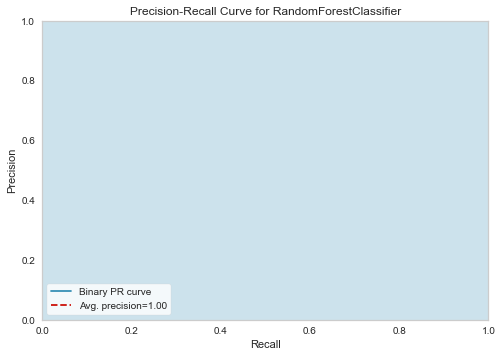

<AxesSubplot:title={'center':'Precision-Recall Curve for RandomForestClassifier'}, xlabel='Recall', ylabel='Precision'>

In [34]:

viz = PrecisionRecallCurve(RandomForestClassifier())
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.show()

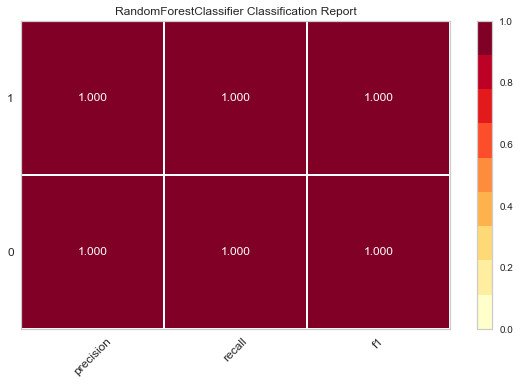

<AxesSubplot:title={'center':'RandomForestClassifier Classification Report'}>

In [35]:

viz = ClassificationReport(RandomForestClassifier())
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.show()

/Users/GLanku/Desktop/not_sure/env/lib/python3.9/site-packages/yellowbrick/classifier/prcurve.py:254: YellowbrickWarning: micro=True is ignored;specify per_class=False to draw a PR curve after micro-averaging
  warnings.warn(


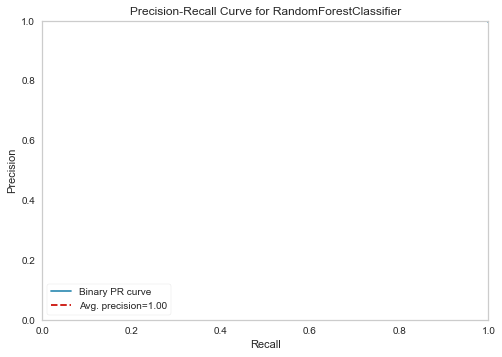

<AxesSubplot:title={'center':'Precision-Recall Curve for RandomForestClassifier'}, xlabel='Recall', ylabel='Precision'>

In [38]:
viz = PrecisionRecallCurve(
    RandomForestClassifier(n_estimators=10),
    per_class=True,
    cmap="Set1"
)
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.show()

In [39]:
import sklearn.metrics as metrics

In [42]:
model_metrics = {
    "accuracy": metrics.accuracy_score,
    "roc":metrics.roc_auc_score,
    "f1_score":metrics.f1_score,
    "f1_micro": lambda y1,y2: metrics.f1_score(y1,y2,average = "micro"),
    "f1_macro" :lambda y1,y2: metrics.f1_score(y1,y2,average = "macro")}

In [43]:
clf = RandomForestClassifier()
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

In [44]:
for name,metric_caller in model_metrics.items():
    print("*******************",name,"***************************")
    print(name, ":", metric_caller(y_test,y_pred))

******************* accuracy ***************************
accuracy : 0.9999238559354299
******************* roc ***************************
roc : 0.999897575964493
******************* f1_score ***************************
f1_score : 0.9998975654727353
******************* f1_micro ***************************
f1_micro : 0.9999238559354299
******************* f1_macro ***************************
f1_macro : 0.9999184864385753


In [47]:
pd.DataFrame(metrics.confusion_matrix(y_true=y_test,y_pred=y_pred))

,0,1
0,24754,0
1,3,14642
